## ToDos:
1. Train-Test-Split
2. EDA
3. Impute missing values
4. BaseLine Model
5. Make Features and Target Stationary
6. Model 

In [1]:
# Import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
sns.set()

In [2]:
def plot_time_series(dataframe, min_date, max_date, size):
    if type(dataframe) == pd.Series:
        f, ax = plt.subplots(nrows=1, ncols=1, figsize=size)
        sns.lineplot(x=dataframe.index, y=dataframe)
        ax.set_xlim([datetime.strptime(min_date, "%Y-%m-%d"), datetime.strptime(max_date, "%Y-%m-%d")])

    else:
        f, ax = plt.subplots(nrows=len(dataframe.columns), ncols=1, figsize=size)
        for element in enumerate(dataframe.columns):
            sns.lineplot(x=dataframe.index, y=dataframe[element[1]], ax=ax[element[0]])
            ax[element[0]].set_xlim([datetime.strptime(min_date, "%Y-%m-%d"), datetime.strptime(max_date, "%Y-%m-%d")])

    plt.show()

In [1393]:
df = pd.read_csv("./data/Aquifer_Petrignano.csv", index_col=0, parse_dates=True, dayfirst=True)
df.index.freq = 'D'

In [1394]:
print(df.columns)
columns = ['Rf_BU', 'DtG_P24', 'DtG_P25', 'T_BU', 'T_Pe', 'V_Pe', 'H_FCP']
df.columns = columns

Index(['Rainfall_Bastia_Umbra', 'Depth_to_Groundwater_P24',
       'Depth_to_Groundwater_P25', 'Temperature_Bastia_Umbra',
       'Temperature_Petrignano', 'Volume_C10_Petrignano',
       'Hydrometry_Fiume_Chiascio_Petrignano'],
      dtype='object')


In [5]:
df.head(1)

,Rf_BU,DtG_P24,DtG_P25,T_BU,T_Pe,V_Pe,H_FCP
Date,,,,,,,
2006-03-14,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN


In [6]:
df.count()

Rf_BU      4199
DtG_P24    5168
DtG_P25    5184
T_BU       4199
T_Pe       4199
V_Pe       5025
H_FCP      4199
dtype: int64

In [7]:
df.isna().sum()

Rf_BU      1024
DtG_P24      55
DtG_P25      39
T_BU       1024
T_Pe       1024
V_Pe        198
H_FCP      1024
dtype: int64

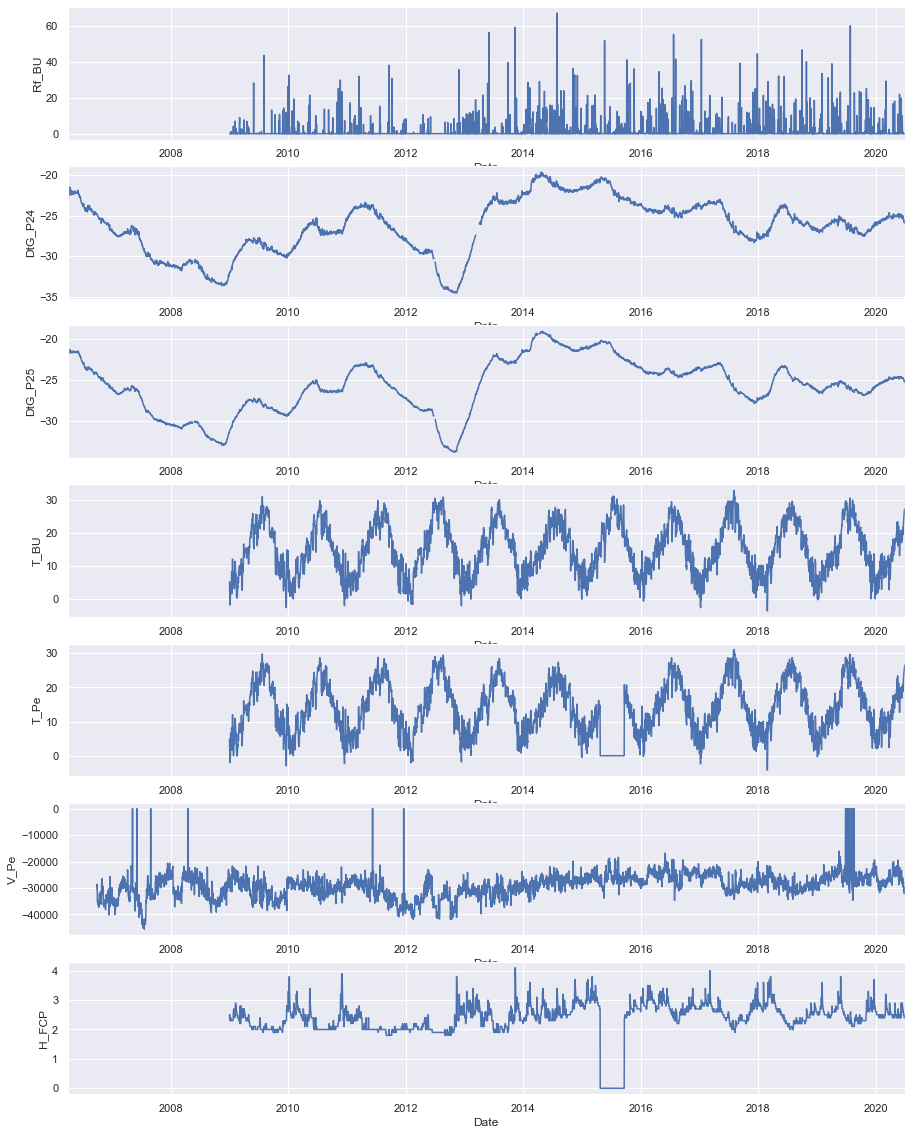

In [58]:
plot_time_series(df, '2006-04-01', '2020-06-30', (15, 20))

### Replace zero values of V_Pe, H_FCP, T_Pe with NaN

In [1395]:
df_imputed = df.copy()

In [1396]:
df_imputed['T_Pe'] = np.where(((df['T_Pe'] == 0) & (df['T_Pe'].shift(1) == 0)) | (df['T_Pe'].diff(-1) > 10) | ((df['T_Pe'] == 0) & (df['T_Pe'].shift(-1) == 0)), np.nan, df['T_Pe'])
df_imputed['V_Pe'] = np.where(df['V_Pe'] == 0, np.nan, df['V_Pe'])
df_imputed['H_FCP'] = np.where(df['H_FCP'] == 0, np.nan, df['H_FCP'])

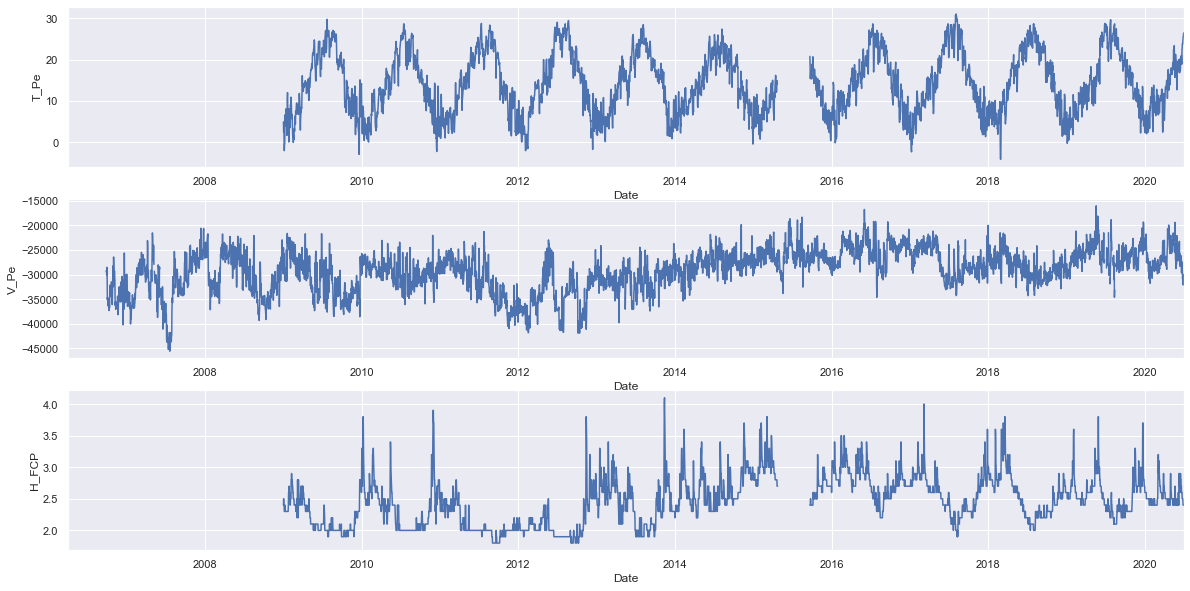

In [28]:
plot_time_series(df_imputed[['T_Pe', 'V_Pe', 'H_FCP']], '2006-04-01', '2020-06-30', (20,10))

### Replace NaN in dataset

#### T_Pe

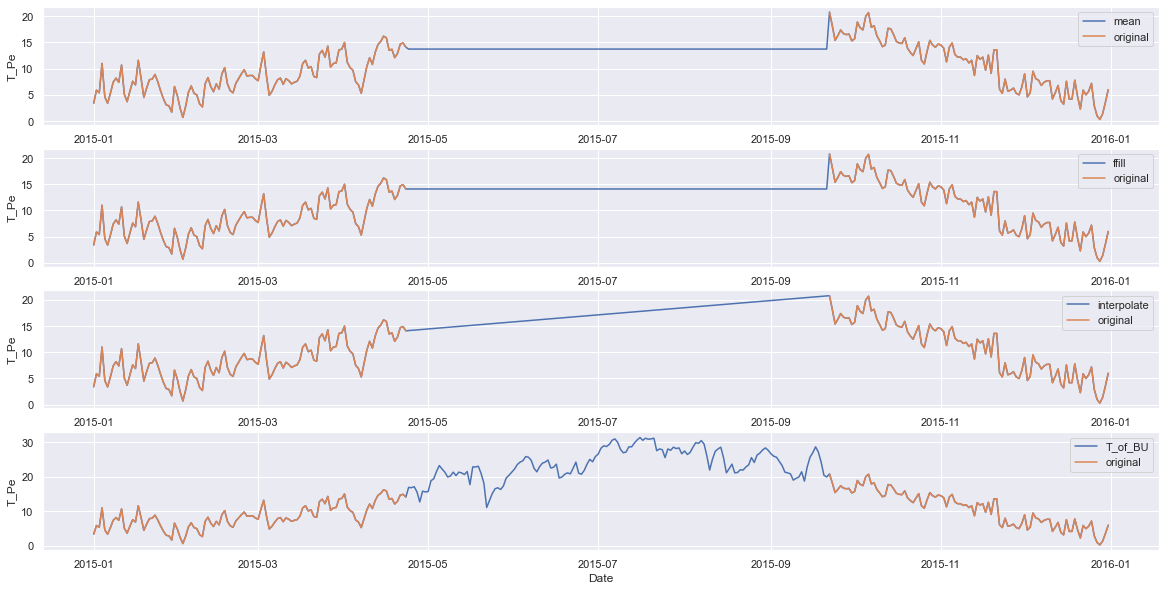

In [12]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(20,10))
subset = df_imputed.loc['2015']

sns.lineplot(x=subset.index, y=subset['T_Pe'].fillna(df['T_Pe'].mean()), label='mean', ax=ax[0])
sns.lineplot(x=subset.index, y=subset['T_Pe'], label='original', ax=ax[0])

sns.lineplot(x=subset.index, y=subset['T_Pe'].ffill(), label='ffill', ax=ax[1])
sns.lineplot(x=subset.index, y=subset['T_Pe'], label='original', ax=ax[1])

sns.lineplot(x=subset.index, y=subset['T_Pe'].interpolate(), label='interpolate', ax=ax[2])
sns.lineplot(x=subset.index, y=subset['T_Pe'], label='original', ax=ax[2])

sns.lineplot(x=subset.index, y=subset['T_Pe'].fillna(df['T_BU']), label='T_of_BU', ax=ax[3])
sns.lineplot(x=subset.index, y=subset['T_Pe'], label='original', ax=ax[3])

plt.legend()
plt.show()

#### V_Pe

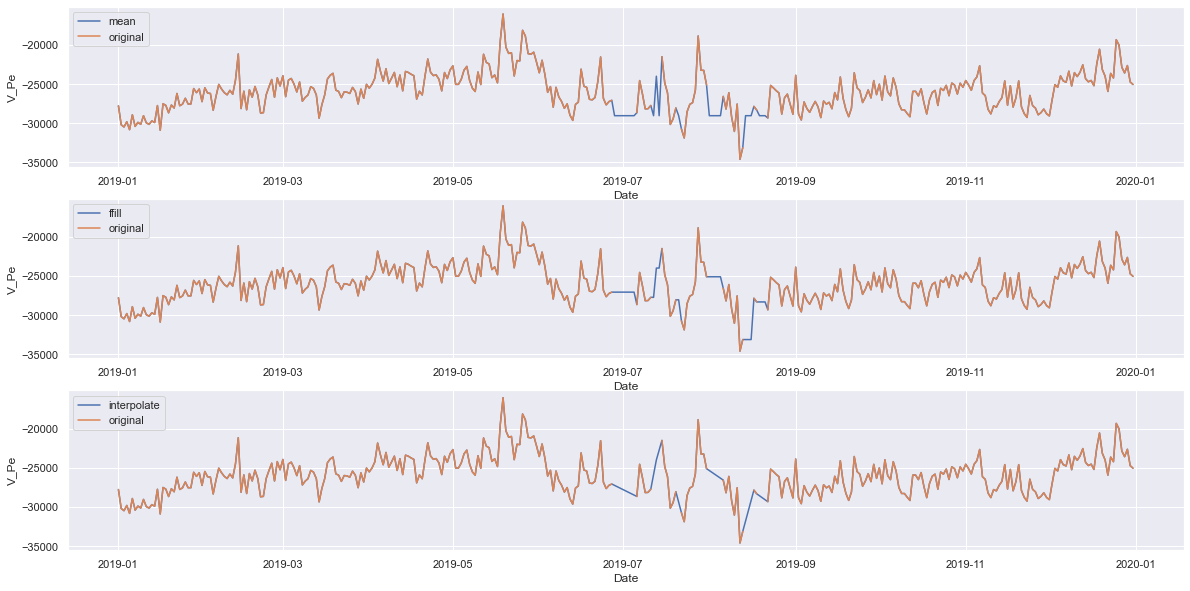

In [13]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10))
subset = df_imputed.loc['2019']

sns.lineplot(x=subset.index, y=subset['V_Pe'].fillna(df['V_Pe'].mean()), label='mean', ax=ax[0])
sns.lineplot(x=subset.index, y=subset['V_Pe'], label='original', ax=ax[0])

sns.lineplot(x=subset.index, y=subset['V_Pe'].ffill(), label='ffill', ax=ax[1])
sns.lineplot(x=subset.index, y=subset['V_Pe'], label='original', ax=ax[1])

sns.lineplot(x=subset.index, y=subset['V_Pe'].interpolate(), label='interpolate', ax=ax[2])
sns.lineplot(x=subset.index, y=subset['V_Pe'], label='original', ax=ax[2])

plt.legend()
plt.show()

#### H_FCP

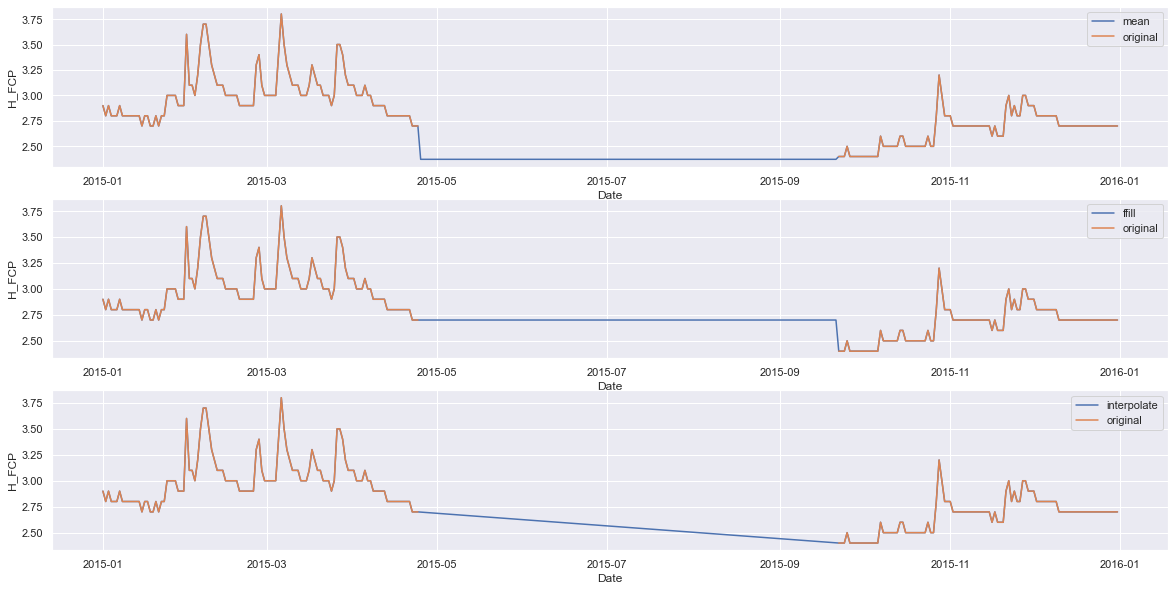

In [14]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10))
subset = df_imputed.loc['2015']

sns.lineplot(x=subset.index, y=subset['H_FCP'].fillna(df['H_FCP'].mean()), label='mean', ax=ax[0])
sns.lineplot(x=subset.index, y=subset['H_FCP'], label='original', ax=ax[0])

sns.lineplot(x=subset.index, y=subset['H_FCP'].ffill(), label='ffill', ax=ax[1])
sns.lineplot(x=subset.index, y=subset['H_FCP'], label='original', ax=ax[1])

sns.lineplot(x=subset.index, y=subset['H_FCP'].interpolate(), label='interpolate', ax=ax[2])
sns.lineplot(x=subset.index, y=subset['H_FCP'], label='original', ax=ax[2])

plt.legend()
plt.show()

#### DtG_P24

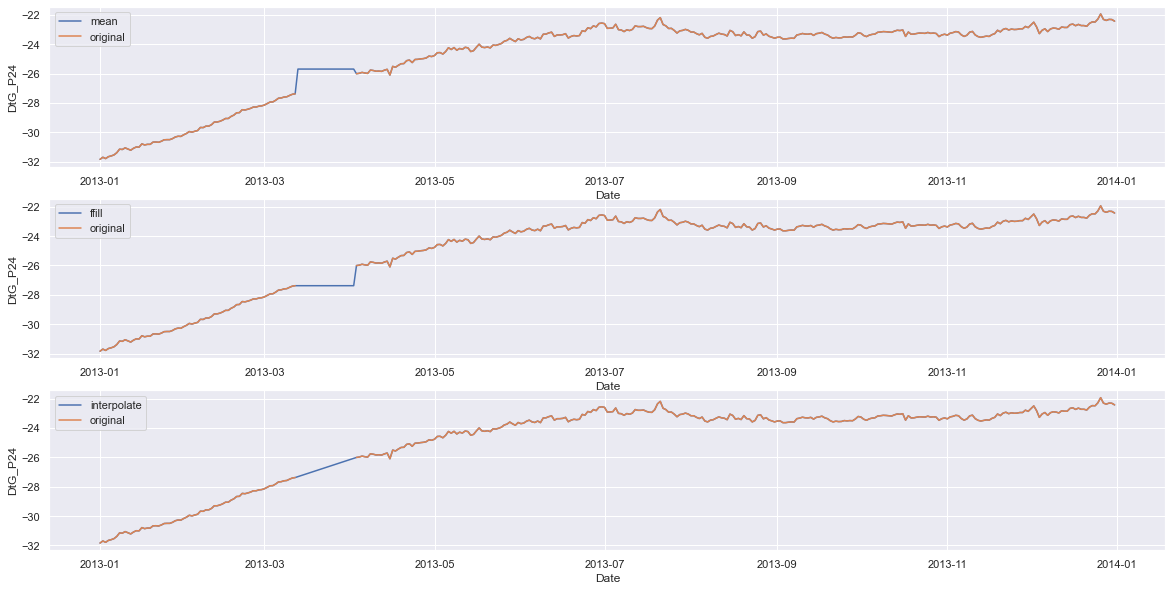

In [15]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10))
subset = df_imputed.loc['2013']

sns.lineplot(x=subset.index, y=subset['DtG_P24'].fillna(df['DtG_P25'].mean()), label='mean', ax=ax[0])
sns.lineplot(x=subset.index, y=subset['DtG_P24'], label='original', ax=ax[0])

sns.lineplot(x=subset.index, y=subset['DtG_P24'].ffill(), label='ffill', ax=ax[1])
sns.lineplot(x=subset.index, y=subset['DtG_P24'], label='original', ax=ax[1])

sns.lineplot(x=subset.index, y=subset['DtG_P24'].interpolate(), label='interpolate', ax=ax[2])
sns.lineplot(x=subset.index, y=subset['DtG_P24'], label='original', ax=ax[2])

plt.legend()
plt.show()

### Impute missing values

In [1397]:
df_imputed['T_Pe'] = df['T_Pe'].fillna(df['T_BU'])
df_imputed['V_Pe'] = df_imputed['V_Pe'].interpolate()
df_imputed['H_FCP'] = df_imputed['H_FCP'].interpolate()
df_imputed['DtG_P25'] = df_imputed['DtG_P25'].interpolate()
df_imputed['DtG_P24'] = df_imputed['DtG_P24'].interpolate()

## Check for consistent spacing

In [1398]:
(df_imputed.index - df_imputed.index.shift(-1)).value_counts()

1 days    5223
Name: Date, dtype: int64

## Downsampling

In [1399]:
col_mean = ['DtG_P25', 'H_FCP', 'V_Pe', 'T_BU']
col_sum = ['Rf_BU']
df_weekly = df_imputed[col_mean].resample('7D').mean()
df_weekly['Rf_BU'] = df_imputed[col_sum].resample('7D').sum()
df_weekly = df_weekly.loc['2009':]
df_weekly['timestep'] = range(len(df_weekly.index))

### Decompose features

In [13]:
def decompose_features(series, per):
    results = seasonal_decompose(series, model='additive', period=per, extrapolate_trend='freq')
    f, ax = plt.subplots(nrows=4, ncols=1, figsize=(20,10))
    sns.lineplot(x=series.index, y=results.observed, ax=ax[0])
    sns.lineplot(x=series.index, y=results.trend, ax=ax[1])
    sns.lineplot(x=series.index, y=results.seasonal, ax=ax[2])
    sns.lineplot(x=series.index, y=results.resid, ax=ax[3])
    plt.show()
    
    return results

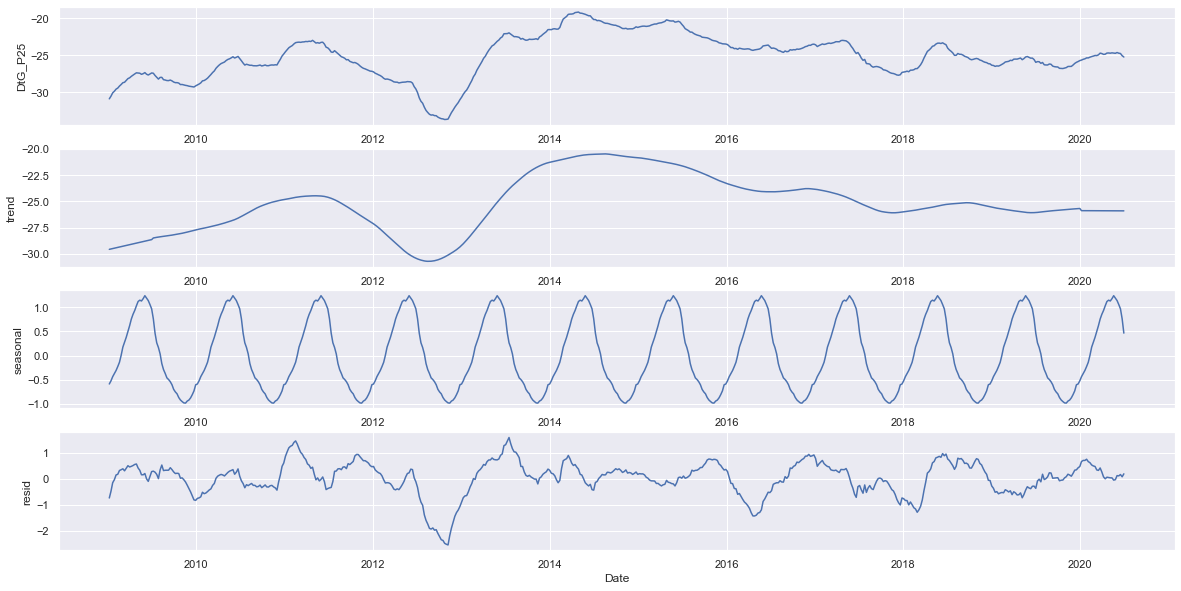

In [16]:
y_decompose = decompose_features(df_weekly['DtG_P25'], 52)

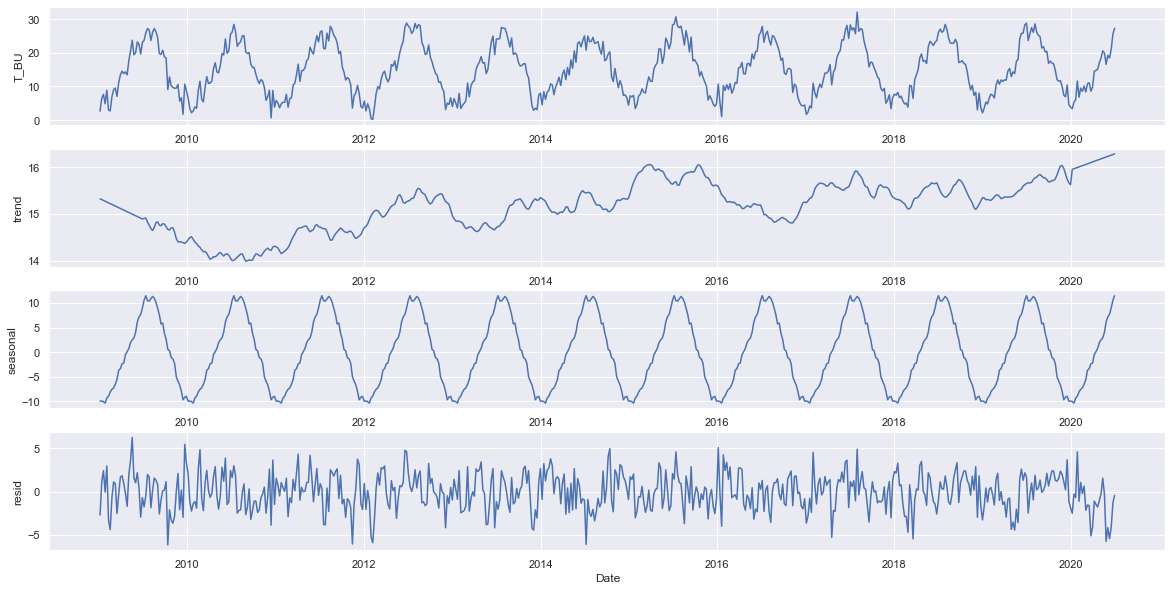

In [17]:
temp = df_weekly['T_BU']
temp_decompose = decompose_features(temp, 52)

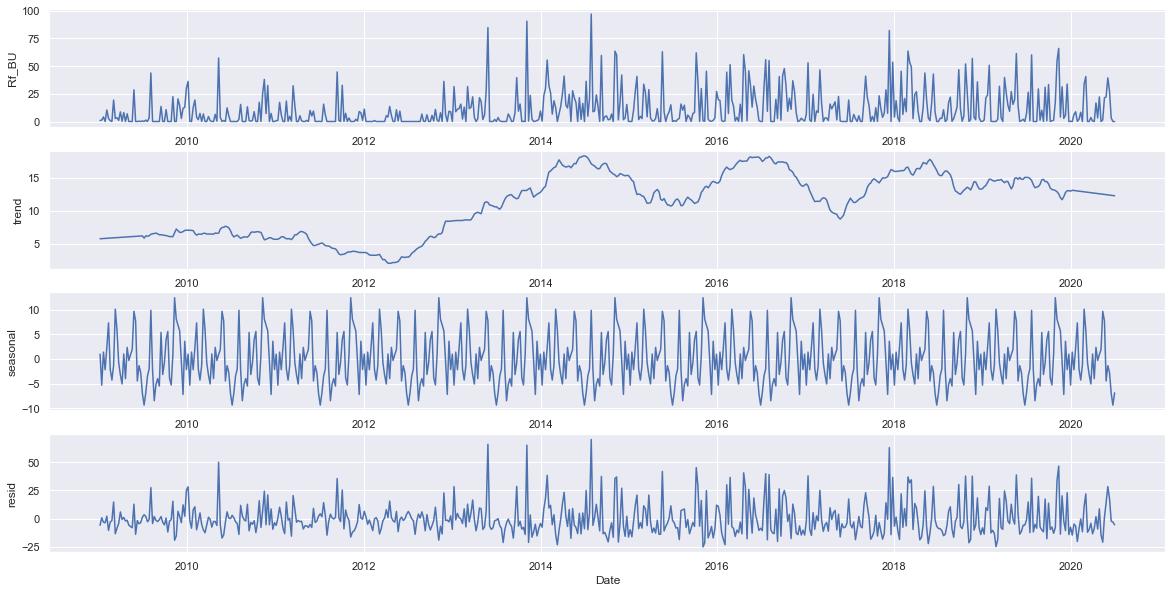

In [18]:
rainfall = df_weekly['Rf_BU']
rainfall_decompose = decompose_features(rainfall, 52)

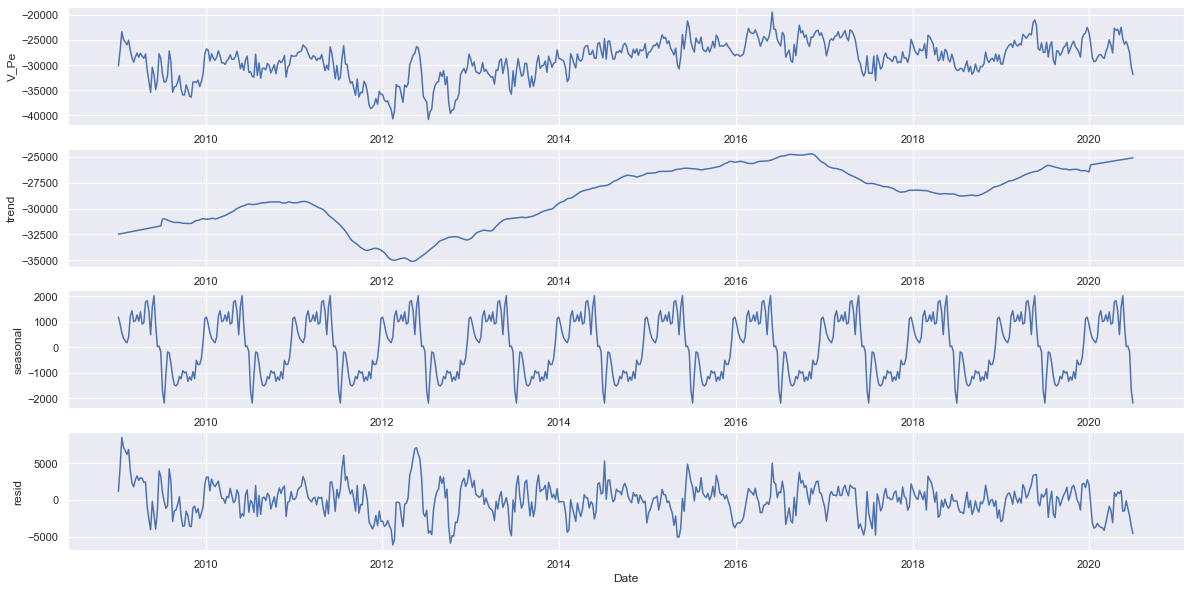

In [19]:
extraction = df_weekly['V_Pe']
extraction_decompose = decompose_features(extraction, 52)

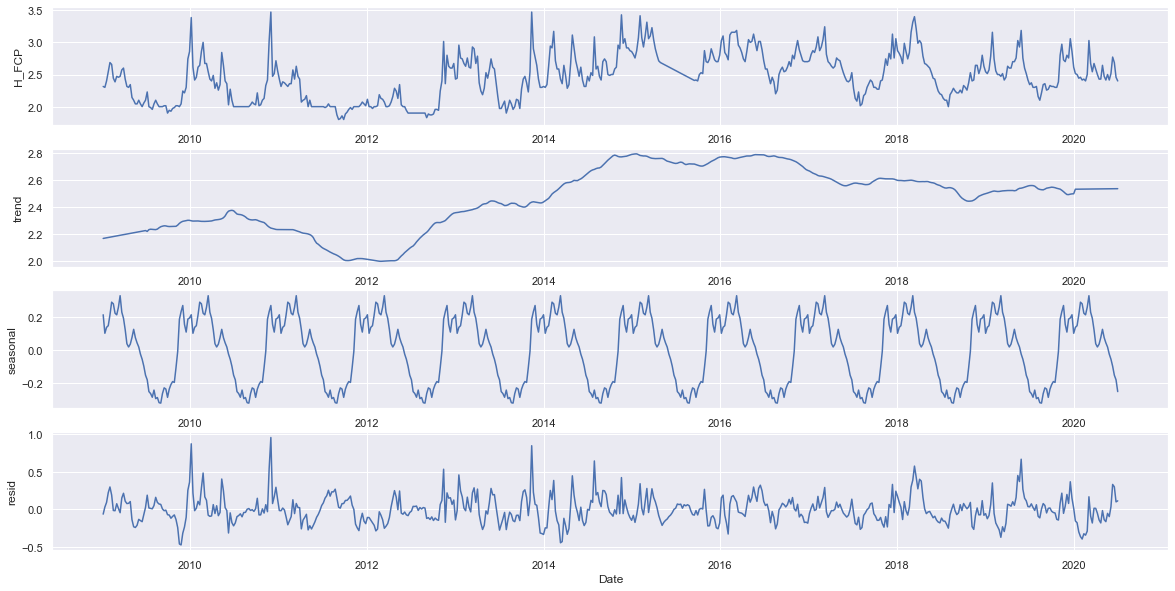

In [20]:
hydrometry = df_weekly['H_FCP']
hydrometry_decompose = decompose_features(hydrometry, 52)

In [1162]:
df_decomposed = pd.DataFrame(index=df_weekly.index)
features = [y_decompose, temp_decompose, rainfall_decompose, extraction_decompose, hydrometry_decompose]
for feature in features:
    df_decomposed[f'{feature.observed.name}'] = feature.observed
    df_decomposed[f'{feature.observed.name}_trend'] = feature.trend
    df_decomposed[f'{feature.observed.name}_seasonal'] = feature.seasonal

AttributeError: 'numpy.ndarray' object has no attribute 'set_xlim'

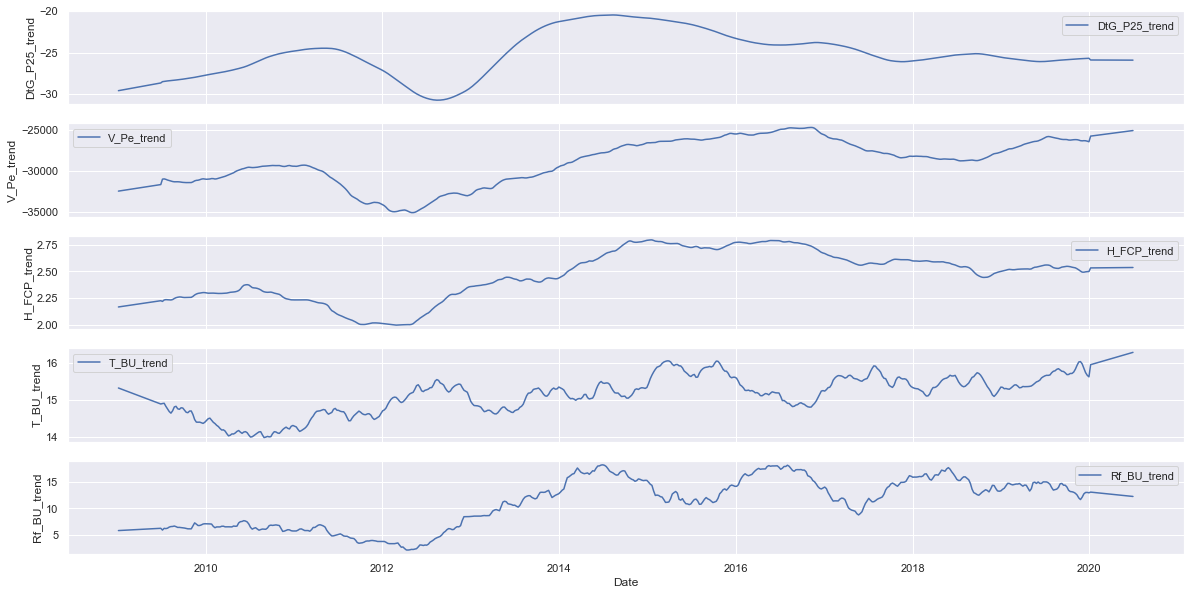

In [787]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(20,10), sharex=True)

sns.lineplot(x=df_decomposed.index, y=df_decomposed['DtG_P25_trend'], label='DtG_P25_trend', ax=ax[0])
sns.lineplot(x=df_decomposed.index, y=df_decomposed['V_Pe_trend'], label='V_Pe_trend', ax=ax[1])
sns.lineplot(x=df_decomposed.index, y=df_decomposed['H_FCP_trend'], label='H_FCP_trend', ax=ax[2])
sns.lineplot(x=df_decomposed.index, y=df_decomposed['T_BU_trend'], label='T_BU_trend', ax=ax[3])
sns.lineplot(x=df_decomposed.index, y=df_decomposed['Rf_BU_trend'], label='Rf_BU_trend', ax=ax[4])

ax.set_xlim([date(2016, 1, 1), date(2020, 7, 1)])
plt.legend()
plt.show()

In [1163]:
df_decomposed['V_Pe_trend_2M'] = df_decomposed['V_Pe_trend'].shift(2*4)
df_decomposed['H_FCP_trend_2M'] = df_decomposed['H_FCP_trend'].shift(2*4)
df_decomposed['Rf_BU_trend_2M'] = df_decomposed['Rf_BU_trend'].shift(2*4)

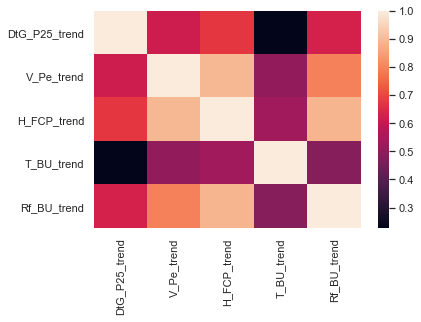

In [25]:
col_trend = ['DtG_P25_trend', 'V_Pe_trend', 'H_FCP_trend', 'T_BU_trend', 'Rf_BU_trend']
corr_trend =  df_decomposed[col_trend].corr()
sns.heatmap(corr_trend)

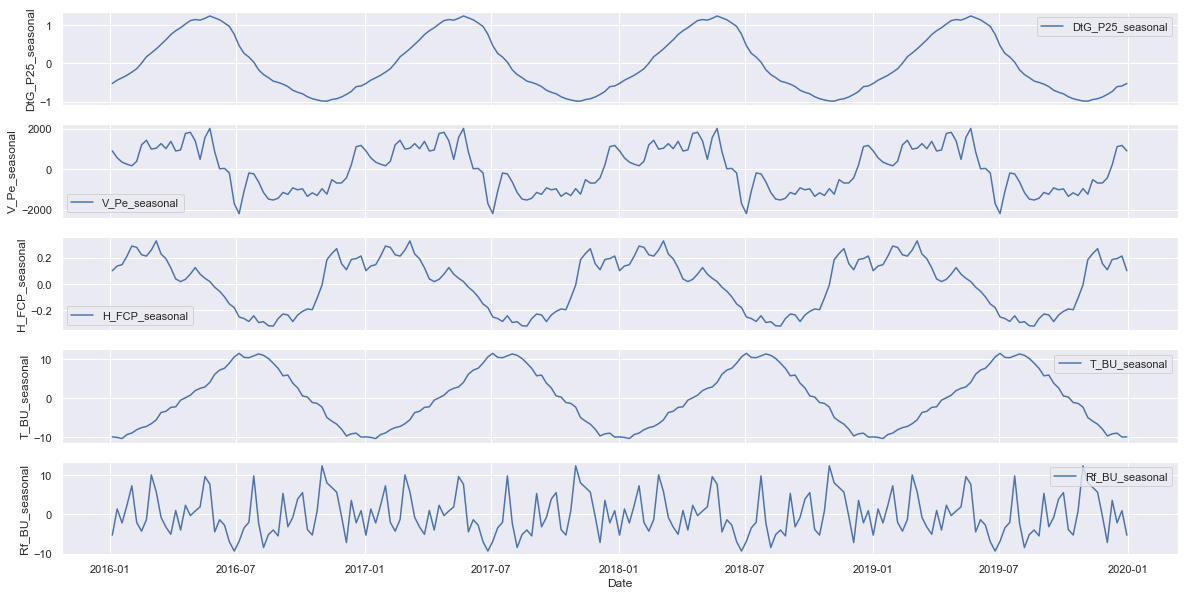

In [26]:
subset_dec = df_decomposed['2016':'2019']

f, ax = plt.subplots(nrows=5, ncols=1, figsize=(20,10), sharex=True)

sns.lineplot(x=subset_dec.index, y=subset_dec['DtG_P25_seasonal'], label='DtG_P25_seasonal', ax=ax[0])
sns.lineplot(x=subset_dec.index, y=subset_dec['V_Pe_seasonal'], label='V_Pe_seasonal', ax=ax[1])
sns.lineplot(x=subset_dec.index, y=subset_dec['H_FCP_seasonal'], label='H_FCP_seasonal', ax=ax[2])
sns.lineplot(x=subset_dec.index, y=subset_dec['T_BU_seasonal'], label='T_BU_seasonal', ax=ax[3])
sns.lineplot(x=subset_dec.index, y=subset_dec['Rf_BU_seasonal'], label='Rf_BU_seasonal', ax=ax[4])

plt.legend()
plt.show()

In [29]:
col_seasonal = ['DtG_P25_seasonal', 'V_Pe_seasonal', 'H_FCP_seasonal', 'T_BU_seasonal', 'Rf_BU_seasonal']
df_decomposed[col_seasonal].groupby(df_decomposed.index.month).agg([np.mean]).round(2)

,DtG_P25_seasonal,V_Pe_seasonal,H_FCP_seasonal,T_BU_seasonal,Rf_BU_seasonal
,mean,mean,mean,mean,mean
Date,,,,,
1,-0.42,563.49,0.16,-9.87,-0.24
2,-0.04,797.03,0.25,-7.88,0.38
3,0.48,1138.14,0.23,-4.47,1.29
4,0.95,1342.23,0.05,-0.66,-0.78
5,1.17,1334.15,0.06,2.98,3.81
6,1.03,-71.77,-0.10,7.91,-4.07
7,0.29,-1052.18,-0.25,10.76,-2.40
8,-0.32,-1170.83,-0.30,10.13,-4.22


## Relative feature lags 
- Groundwater Level - Maximum in Mai/June - Minimum in Oktober/November
- Drainage (inversed negative) - Minimum in March/April - Maximum in June-August
- Hydrometry - Maximum in February/March - Minimum in June - August
- Temperatur - Maximum in June-August - Minimum in January/December
- Rainfall - Maximum in November, Minimum in June - August 

- Temperature lags 2 Month behind Groundwater Level
- Drainage lags -1 Month behind Groundwater Level
- Hydrometry lag -3 Month behind Groundwater Level

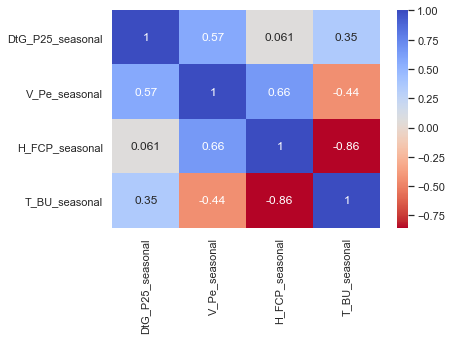

In [30]:
col_seas = ['DtG_P25_seasonal', 'V_Pe_seasonal', 'H_FCP_seasonal', 'T_BU_seasonal']
corr_seas =  df_decomposed[col_seas].corr()
sns.heatmap(corr_seas, cmap='coolwarm_r', annot=True)

In [1164]:
df_decomposed['V_Pe_seasonal_1M'] = df_decomposed['V_Pe_seasonal'].shift(1*4)
df_decomposed['H_FCP_seasonal_3M'] = df_decomposed['H_FCP_seasonal'].shift(3*4)
df_decomposed['T_BU_seasonal_2Mr'] = df_decomposed['T_BU_seasonal'].shift(-2*4)

In [1054]:
df_decomposed['V_Pe_seasonal']

Date
2009-01-06    1180.686975
2009-01-13     909.073788
2009-01-20     566.355526
2009-01-27     352.243302
2009-02-03     249.896096
                 ...     
2020-06-02      23.721138
2020-06-09      42.173563
2020-06-16    -183.664177
2020-06-23   -1701.480156
2020-06-30   -2197.815709
Freq: 7D, Name: V_Pe_seasonal, Length: 600, dtype: float64

In [1055]:
col_seasonal = ['DtG_P25_seasonal', 'V_Pe_seasonal_1M', 'H_FCP_seasonal_3M', 'T_BU_seasonal_2Mr']
df_decomposed[col_seasonal].groupby(df_decomposed.index.month).agg([np.mean]).round(2)

,DtG_P25_seasonal,V_Pe_seasonal_1M,H_FCP_seasonal_3M,T_BU_seasonal_2Mr
,mean,mean,mean,mean
Date,,,,
1,-0.42,449.84,-0.11,-4.88
2,-0.04,516.18,0.20,-1.21
3,0.48,844.41,0.17,2.30
4,0.95,1133.13,0.18,7.10
5,1.17,1371.08,0.25,10.60
6,1.03,1303.03,0.18,10.59
7,0.29,-288.23,0.06,6.14
8,-0.32,-911.89,0.03,0.58


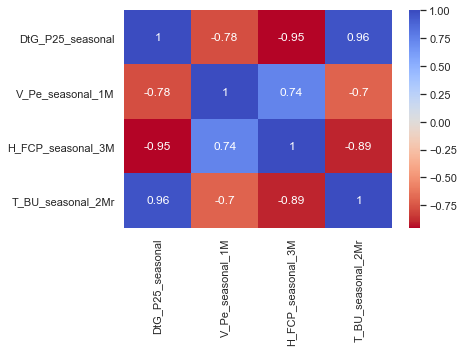

In [34]:
col_seas = ['DtG_P25_seasonal', 'V_Pe_seasonal_1M', 'H_FCP_seasonal_3M', 'T_BU_seasonal_2Mr']
corr_seas =  df_decomposed[col_seas].corr()
sns.heatmap(corr_seas, cmap='coolwarm_r', annot=True)

## Manual decompose

In [356]:
def ma_decompose(series, window_trend, window_seasonality):
    trend = series.rolling(window_trend).mean()
    seasonality = (series - trend).rolling(window_seasonality).mean()
    residual = series - trend - seasonality
    
    return trend, seasonality, residual 

In [357]:
def plot_decomposition(series, trend, seasonality, residual):
    f, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize = (20,10))
    ax[0].plot(series)
    ax[0].set_ylim([series.min(), series.max()])
    ax[0].set_ylabel = 'Observed'
    ax[1].plot(trend)
    ax[1].set_ylim([series.min(), series.max()])
    ax[1].set_ylabel = 'Trend'
    ax[2].plot(seasonality)
    ax[2].set_ylabel = 'Seasonality'
    ax[3].plot(residual)
    ax[3].set_ylabel = 'Residual'
    #plt.title(series.name)
    plt.show()

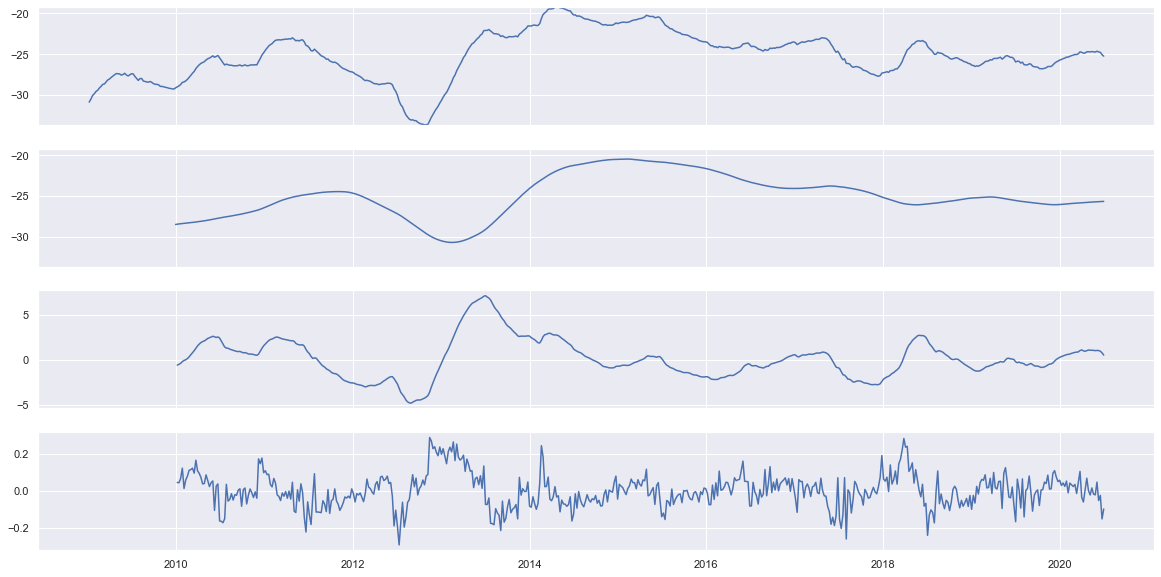

In [360]:
dec_series = df_decomposed.loc['2009-01-01':,'DtG_P25']
trend, seasonality, residual = ma_decompose(dec_series, 52, 2)
plot_decomposition(dec_series, trend, seasonality, residual)

## Train-Test-Split

In [1400]:
# Train-Test-Split

width = 52
for column in df_weekly.iloc[:,:-1]:
    lag = df_weekly.shift(width - 1)
    df_weekly[f'{column}_trend'] = lag[column].rolling(window=width).mean()

df_weekly['V_Pe_trend_2M'] = df_weekly['V_Pe_trend'].shift(2*4)
df_weekly['H_FCP_trend_2M'] = df_weekly['H_FCP_trend'].shift(2*4)
df_weekly['Rf_BU_trend_2M'] = df_weekly['Rf_BU_trend'].shift(2*4) 


train = df_weekly[:-52]
test = df_weekly[-52:]
y_train = train['DtG_P25']
y_test = test['DtG_P25']

## Baseline Model

### Mean

In [107]:
def RSME(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2)).round(2)

def MAE(y_true, y_pred):
    return round(np.mean(np.abs(y_true - y_pred)),2)

In [108]:
y_pred_mean = pd.Series(y_train.mean(), index=test.index)

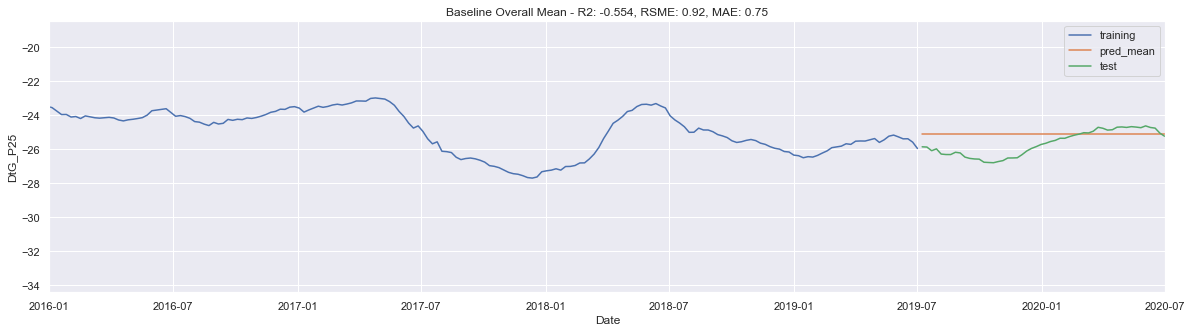

In [109]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
sns.lineplot(x = y_train.index, y=y_train, label='training')
sns.lineplot(x = test.index, y=y_pred_mean, label='pred_mean')
sns.lineplot(x = test.index, y=y_test, label='test')
ax.set_title(f'Baseline Overall Mean - R2: {round(r2_score(y_test, y_pred_mean),3)}, RSME: {RSME(y_test, y_pred_mean)}, MAE: {MAE(y_test, y_pred_mean)}')
ax.set_xlim([date(2016, 1, 1), date(2020, 7, 1)])
plt.show()

### Naive Approach

In [110]:
y_pred_naive = pd.Series(y_train[-1], index=test.index)

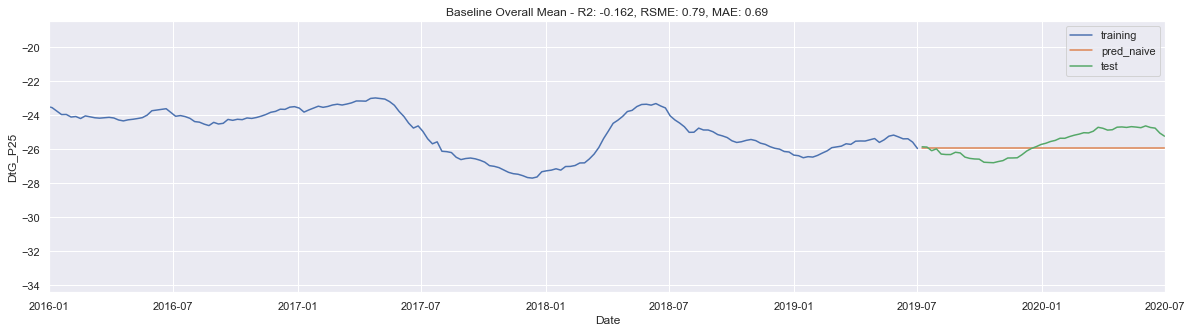

In [111]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
sns.lineplot(x = y_train.index, y=y_train, label='training')
sns.lineplot(x = test.index, y=y_pred_naive, label='pred_naive')
sns.lineplot(x = test.index, y=y_test, label='test')
ax.set_title(f'Baseline Overall Mean - R2: {round(r2_score(y_test, y_pred_naive),3)}, RSME: {RSME(y_test, y_pred_naive)}, MAE: {MAE(y_test, y_pred_naive)}')
ax.set_xlim([date(2016, 1, 1), date(2020, 7, 1)])
plt.show()

### Seasonal Naive

## Cross-Validation 

In [112]:
time_series_split = TimeSeriesSplit(n_splits=5)
splits = time_series_split.split(X_full, y_full) 

cv_manual_ar = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=splits)
print(f'CV-Score (Manual AR): {round(cv_manual_ar.mean(),3)}')

NameError: name 'X_full' is not defined

## ARIMA - univariant

In [113]:
result = adfuller(y_train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.756201
p-value: 0.064808


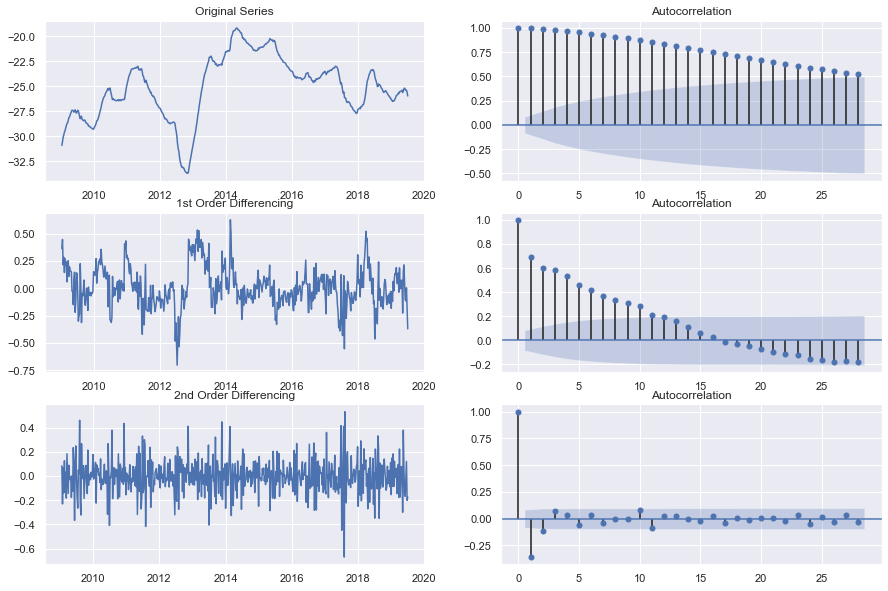

In [114]:
# Original Series
fig, axes = plt.subplots(3, 2, figsize=(15,10))
axes[0, 0].plot(y_train)
axes[0, 0].set_title('Original Series')
plot_acf(y_train, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(y_train.diff().dropna())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(y_train.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(y_train.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(y_train.diff().dropna().diff().dropna(), ax=axes[2, 1])

plt.show()

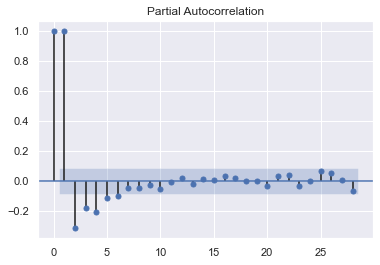

In [115]:
plot_pacf(y_train);

In [116]:
mod = ARIMA(y_train, order=(1,1,1), freq='7D')
res = mod.fit() 
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                DtG_P25   No. Observations:                  548
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 350.918
Date:                Mon, 15 Feb 2021   AIC                           -695.835
Time:                        13:31:37   BIC                           -682.922
Sample:                    01-06-2009   HQIC                          -690.788
                         - 07-02-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9162      0.021     43.814      0.000       0.875       0.957
ma.L1         -0.4774      0.039    -12.090      0.000      -0.555      -0.400
sigma2         0.0162      0.001     22.211      0.000       0.015       0.018
===================================================================================
Ljung-Box (Q):                       31.26   Jarque-Bera (JB):                61.17
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.12
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

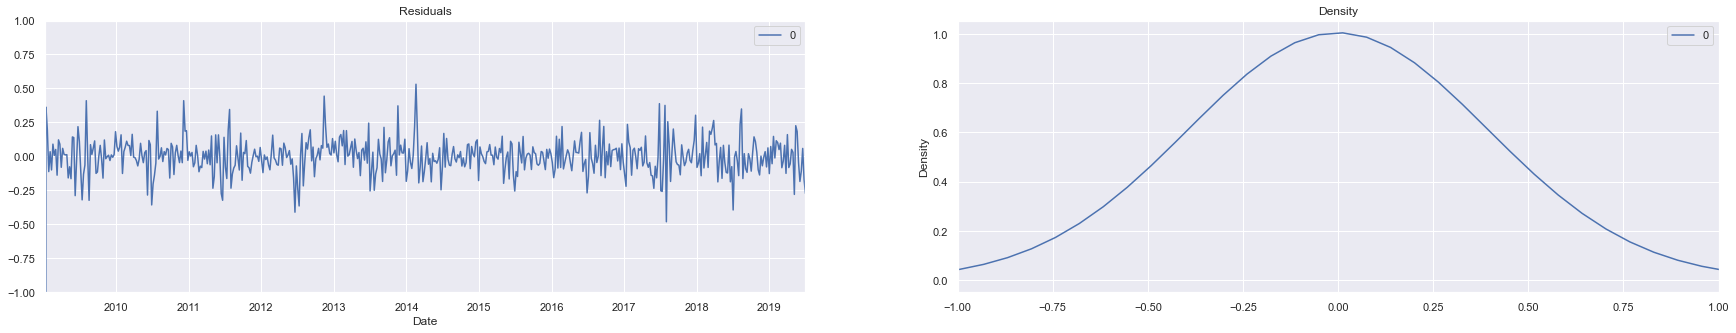

In [117]:
residuals = pd.DataFrame(res.resid)
f, ax = plt.subplots(1, 2, figsize=(30,5))
residuals.plot(title='Residuals', ax=ax[0])
ax[0].set_ylim([-1,1])
residuals.plot(title='Density', kind='kde', ax=ax[1])
ax[1].set_xlim([-1,1])
plt.show()

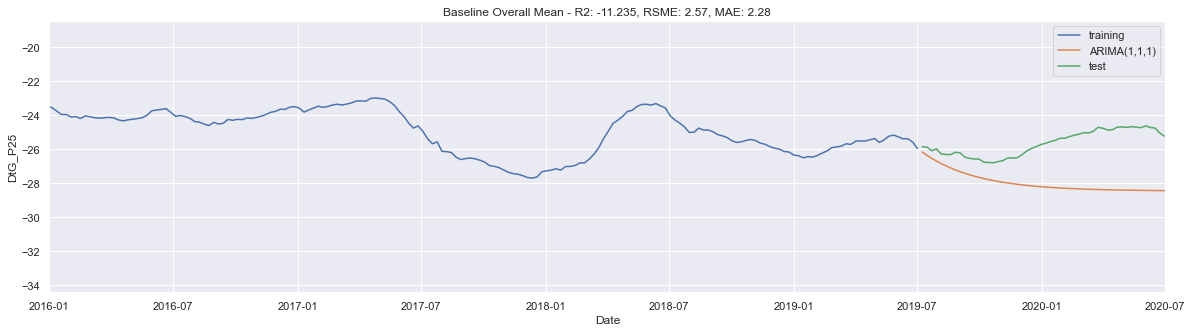

In [118]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
sns.lineplot(x = y_train.index, y=y_train, label='training')
sns.lineplot(x = test.index, y=res.forecast(len(test.index)), label='ARIMA(1,1,1)')
sns.lineplot(x = test.index, y=y_test, label='test')
ax.set_title(f'Baseline Overall Mean - R2: {round(r2_score(y_test, res.forecast(len(test.index))),3)}, RSME: {RSME(y_test, res.forecast(len(test.index)))}, MAE: {MAE(y_test, res.forecast(len(test.index)))}')
ax.set_xlim([date(2016, 1, 1), date(2020, 7, 1)])
plt.show()

In [119]:
month_onehot = pd.get_dummies(y_train.index.month).set_index(y_train.index)
mod = ARIMA(y_train, exog=month_onehot ,order=(1,1,1))
res_sea = mod.fit() 
res_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                DtG_P25   No. Observations:                  548
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 359.032
Date:                Mon, 15 Feb 2021   AIC                           -688.065
Time:                        13:31:47   BIC                           -623.498
Sample:                    01-06-2009   HQIC                          -662.827
                         - 07-02-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
1              0.0333      0.046      0.731      0.464      -0.056       0.123
2             -0.0006      0.043     -0.014      0.989      -0.086       0.084
3              0.0145      0.042      0.344      0.731      -0.068       0.097
4              0.0529      0.038      1.400      0.162      -0.021       0.127
5              0.0300      0.037      0.817      0.414      -0.042       0.102
6              0.0622      0.036      1.732      0.083      -0.008       0.133
7             -0.0412      0.037     -1.128      0.259      -0.113       0.030
8             -0.0764      0.037     -2.053      0.040      -0.149      -0.003
9             -0.0578      0.041     -1.403      0.160      -0.138       0.023
10            -0.0348      0.047     -0.746      0.455      -0.126       0.057
11            -0.0144      0.046     -0.312      0.755      -0.105       0.076
12             0.0303      0.046      0.655      0.513      -0.060       0.121
ar.L1          0.9200      0.022     42.492      0.000       0.878       0.962
ma.L1         -0.4928      0.042    -11.746      0.000      -0.575      -0.411
sigma2         0.0157      0.001     21.323      0.000       0.014       0.017
===================================================================================
Ljung-Box (Q):                       34.83   Jarque-Bera (JB):                63.67
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             0.17
Prob(H) (two-sided):                  0.58   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.17e+16. Standard errors may be unstable.
"""

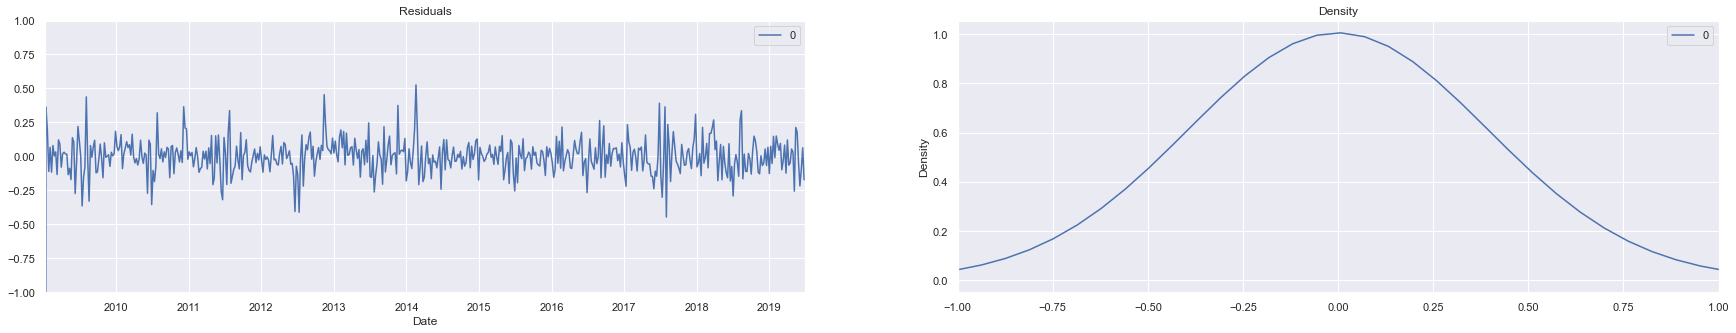

In [120]:
residuals = pd.DataFrame(res_sea.resid)
f, ax = plt.subplots(1, 2, figsize=(30,5))
residuals.plot(title='Residuals', ax=ax[0])
ax[0].set_ylim([-1,1])
residuals.plot(title='Density', kind='kde', ax=ax[1])
ax[1].set_xlim([-1,1])
plt.show()

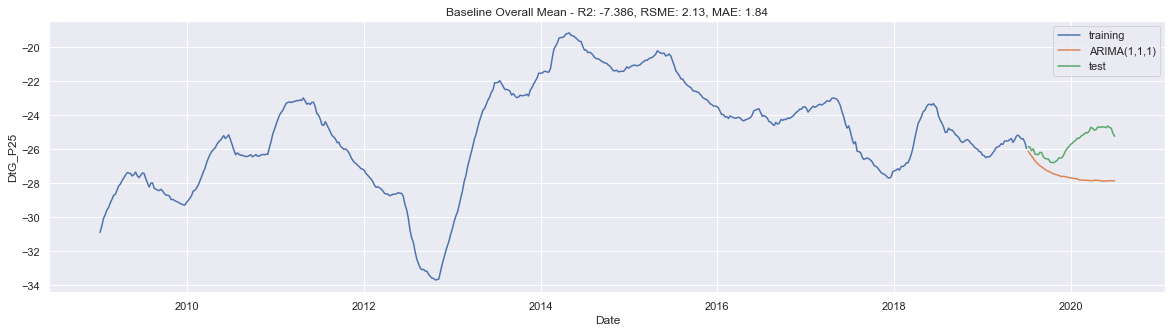

In [121]:
forecast = res_sea.forecast(len(test.index), exog=pd.get_dummies(test.index.month))
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
sns.lineplot(x = y_train.index, y=y_train, label='training')
sns.lineplot(x = test.index, y=forecast, label='ARIMA(1,1,1)')
sns.lineplot(x = test.index, y=y_test, label='test')
ax.set_title(f'Baseline Overall Mean - R2: {round(r2_score(y_test, forecast),3)}, RSME: {RSME(y_test, forecast)}, MAE: {MAE(y_test, forecast)}')
plt.show()

In [122]:
forecast_series = pd.Series(index=y_test.index)
training = y_train.copy()
for date in y_test.index:
    res_m = ARIMA(training, order=(1,1,1)).fit()
    forecast_series.loc[date] = res_m.predict(date).values
    training.loc[date] = y_test.loc[date]

<ipython-input-122-478c9c98ec92>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  forecast_series = pd.Series(index=y_test.index)


In [142]:
forecast_series

Date
2019-07-09   -26.175471
2019-07-16   -25.929375
2019-07-23   -25.919187
2019-07-30   -26.207564
2019-08-06   -25.995039
2019-08-13   -26.428877
2019-08-20   -26.400465
2019-08-27   -26.363529
2019-09-03   -26.152807
2019-09-10   -26.226409
2019-09-17   -26.576161
2019-09-24   -26.632498
2019-10-01   -26.637788
2019-10-08   -26.626481
2019-10-15   -26.867629
2019-10-22   -26.843999
2019-10-29   -26.835970
2019-11-05   -26.722904
2019-11-12   -26.650285
2019-11-19   -26.448247
2019-11-26   -26.483791
2019-12-03   -26.489894
2019-12-10   -26.242882
2019-12-17   -25.981100
2019-12-24   -25.833692
2019-12-31   -25.749197
2020-01-07   -25.625641
2020-01-14   -25.578087
2020-01-21   -25.473917
2020-01-28   -25.423138
2020-02-04   -25.279689
2020-02-11   -25.327603
2020-02-18   -25.204947
2020-02-25   -25.121306
2020-03-03   -25.067139
2020-03-10   -24.976914
2020-03-17   -25.029472
2020-03-24   -24.896750
2020-03-31   -24.600252
2020-04-07   -24.741716
2020-04-14   -24.914486
2020-04-21 

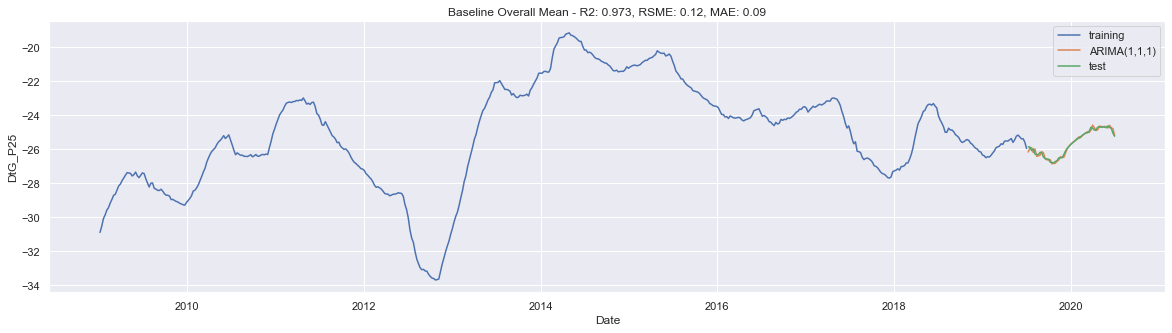

In [124]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
sns.lineplot(x = y_train.index, y=y_train, label='training')
sns.lineplot(x = test.index, y=forecast_series, label='ARIMA(1,1,1)')
sns.lineplot(x = test.index, y=y_test, label='test')
ax.set_title(f'Baseline Overall Mean - R2: {round(r2_score(y_test, forecast_series),3)}, RSME: {RSME(y_test, forecast_series)}, MAE: {MAE(y_test, forecast_series)}')
plt.show()

In [129]:
def arima_time_series_cv(data, splits, metric, order=(1,1,1)):
    split_len = int(len(data)/(splits+1))
    
    error = []
    for split in range(1,splits+1):
        train = data[:split*split_len]
        test = data[split*split_len:split*split_len+split_len]
        model = ARIMA(train, order=order)
        res = model.fit()
        y_pred = res.forecast(len(test.index))
        error.append(metric(test, y_pred))
        
    return error

In [130]:
cv_error = arima_time_series_cv(y_train, 5, MAE)

In [131]:
np.mean(cv_error)

2.692

## Facebook Prophet

In [133]:
from fbprophet import Prophet

In [139]:
y_train_prophet = y_train.reset_index()
y_train_prophet.columns = ['ds', 'y']

In [175]:
m_prophet_1 = Prophet(mcmc_samples=300, yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
m_prophet_1.fit(y_train_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [176]:
future_frame = m_prophet_1.make_future_dataframe(periods=52, freq='7D', include_history=False)
prophet_simple = m_prophet_1.predict(future_frame)

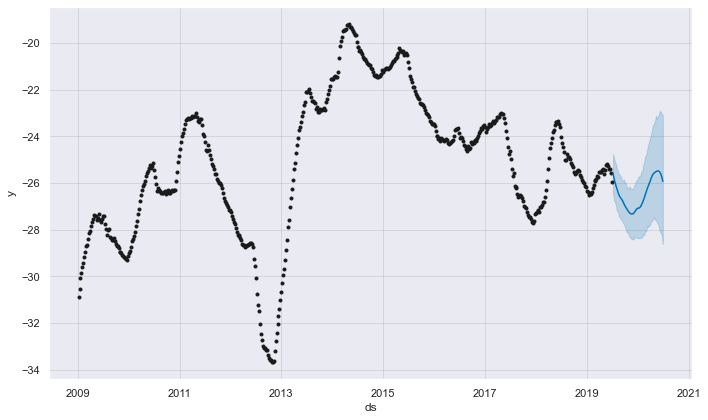

In [177]:
m1 = m_prophet_1.plot(prophet_simple)

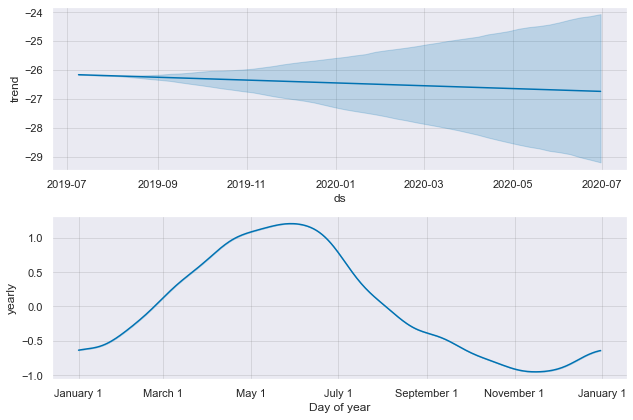

In [178]:
comp = m_prophet_1.plot_components(prophet_simple)

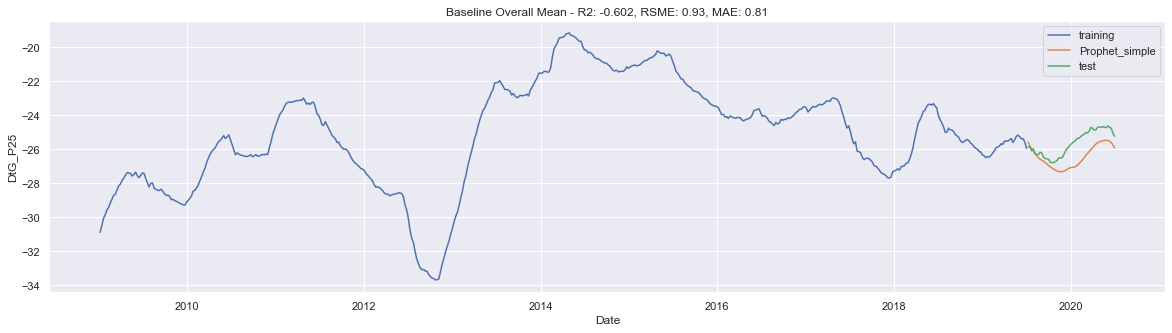

In [174]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
sns.lineplot(x = y_train.index, y=y_train, label='training')
sns.lineplot(x = prophet_simple.ds, y=prophet_simple.yhat, label='Prophet_simple')
sns.lineplot(x = test.index, y=y_test, label='test')
ax.set_title(f'Baseline Overall Mean - R2: {round(r2_score(y_test, prophet_simple.set_index("ds").yhat),3)}, RSME: {RSME(y_test, prophet_simple.set_index("ds").yhat)}, MAE: {MAE(y_test, prophet_simple.set_index("ds").yhat)}')
plt.show()

### Addition of regressors

In [1170]:
train.columns

Index(['DtG_P25', 'H_FCP', 'V_Pe', 'T_BU', 'Rf_BU', 'timestep'], dtype='object')

In [191]:
train_prophet = train.reset_index()
train_prophet.rename(columns = {'Date' : 'ds', 'DtG_P25' : 'y'}, inplace=True)

In [219]:
regressors = ['T_BU', 'Rf_BU', 'V_Pe', 'H_FCP']
m_prophet_2 = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
for regressor in regressors:
    m_prophet_2.add_regressor(regressor, mode='additive')
m_prophet_2.fit(train_prophet)

In [220]:
future_frame = m_prophet_2.make_future_dataframe(periods=52, freq='7D', include_history=False)

In [221]:
future_frame = future_frame.join(test[regressors].reset_index(drop=True))

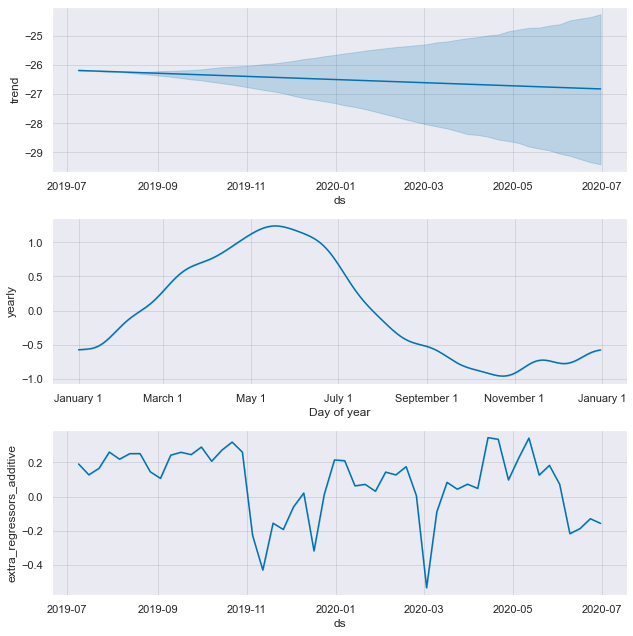

In [224]:
prophet_complex = m_prophet_2.predict(future_frame)
fig = m_prophet_2.plot_components(prophet_complex)

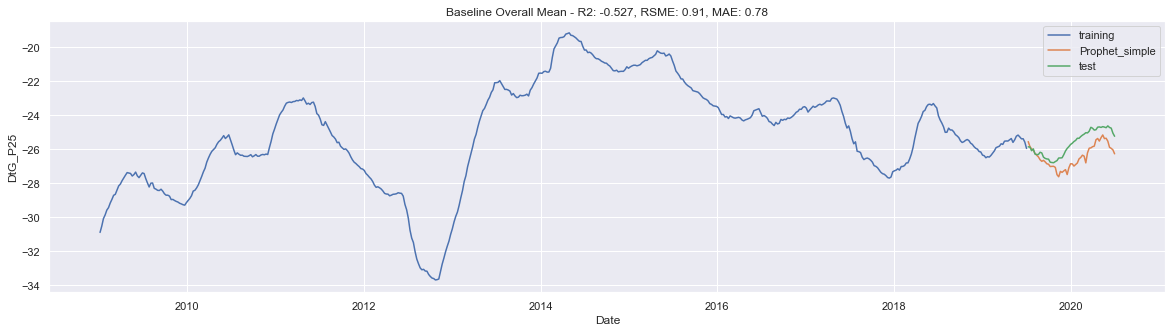

In [226]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
sns.lineplot(x = y_train.index, y=y_train, label='training')
sns.lineplot(x = prophet_simple.ds, y=prophet_complex.yhat, label='Prophet_simple')
sns.lineplot(x = test.index, y=y_test, label='test')
ax.set_title(f'Baseline Overall Mean - R2: {round(r2_score(y_test, prophet_complex.set_index("ds").yhat),3)}, RSME: {RSME(y_test, prophet_complex.set_index("ds").yhat)}, MAE: {MAE(y_test, prophet_complex.set_index("ds").yhat)}')
plt.show()

## XBoost Trees

In [335]:
# Adapted machinelearningmastery.com (https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)
def series_to_supervised(df, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Pandas DataFrame
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = df.shape[1]
    var_name = df.columns
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(f'{var_name[j]}(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(f'{var_name[j]}(t)') for j in range(n_vars)]
        else:
            names += [(f'{var_name[j]}' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [300]:
def cv_split(data, splits):
    split_len = int(len(data)/(splits+1))
    
    train_splits = []
    val_splits = []
    for split in range(1,splits+1):
        train = data[:split*split_len]
        val = data[split*split_len:split*split_len+split_len]
        train_splits.append(train)
        val_splits.append(val)
        
    return train_splits, val_splits

In [1401]:
train.columns

Index(['DtG_P25', 'H_FCP', 'V_Pe', 'T_BU', 'Rf_BU', 'timestep',
       'DtG_P25_trend', 'H_FCP_trend', 'V_Pe_trend', 'T_BU_trend',
       'Rf_BU_trend', 'V_Pe_trend_2M', 'H_FCP_trend_2M', 'Rf_BU_trend_2M'],
      dtype='object')

In [571]:
def season(date):
    return date.month%12 // 3 + 1

In [1402]:
x_columns = ['T_BU', 'Rf_BU', 'V_Pe', 'H_FCP', 'V_Pe_trend_2M', 'H_FCP_trend_2M']
y_train = train['DtG_P25']
X_train = train[x_columns]
X_train = X_train.join(pd.get_dummies(season(X_train.index), drop_first=True).set_index(X_train.index))
X_train['year'] = X_train.index.year
y_test = test['DtG_P25']
X_test = test[x_columns]
X_test = X_test.join(pd.get_dummies(season(X_test.index), drop_first=True).set_index(X_test.index))
X_test['year'] = X_test.index.year

In [1403]:
from catboost import CatBoostRegressor

In [1404]:
boost = CatBoostRegressor(iterations=200, learning_rate=0.05, depth=3, verbose=False)

In [1405]:
boost.fit(X_train, y_train)

In [1406]:
yhat = pd.Series(boost.predict(X_train), index=X_train.index)

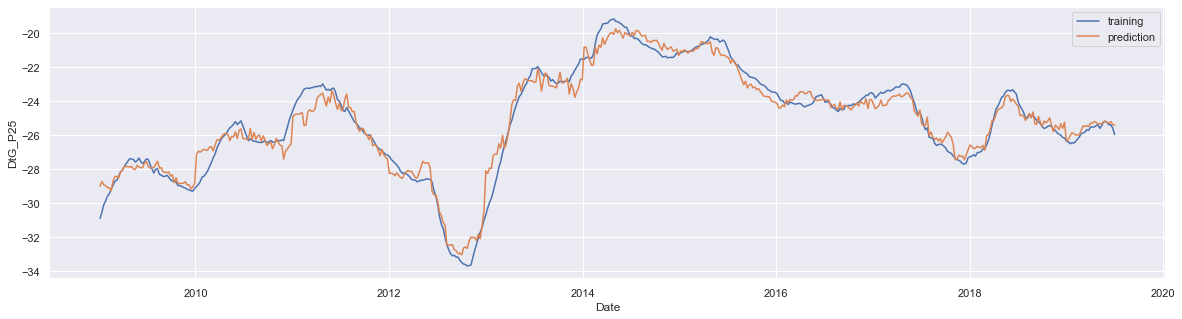

In [1407]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
sns.lineplot(x = y_train.index, y=y_train, label='training')
sns.lineplot(x = yhat.index, y=yhat, label='prediction')
plt.show()

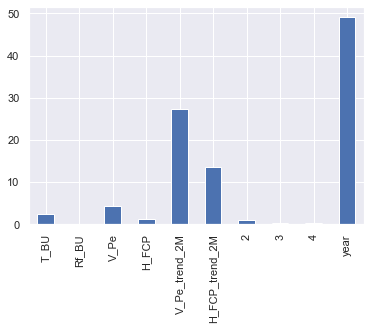

In [1408]:
pd.Series(boost.feature_importances_, index=X_train.columns).plot(kind='bar')

### CV Xboost

In [1409]:
X_training, X_validation = cv_split(X_train, 5)
y_training, y_validation = cv_split(y_train, 5)

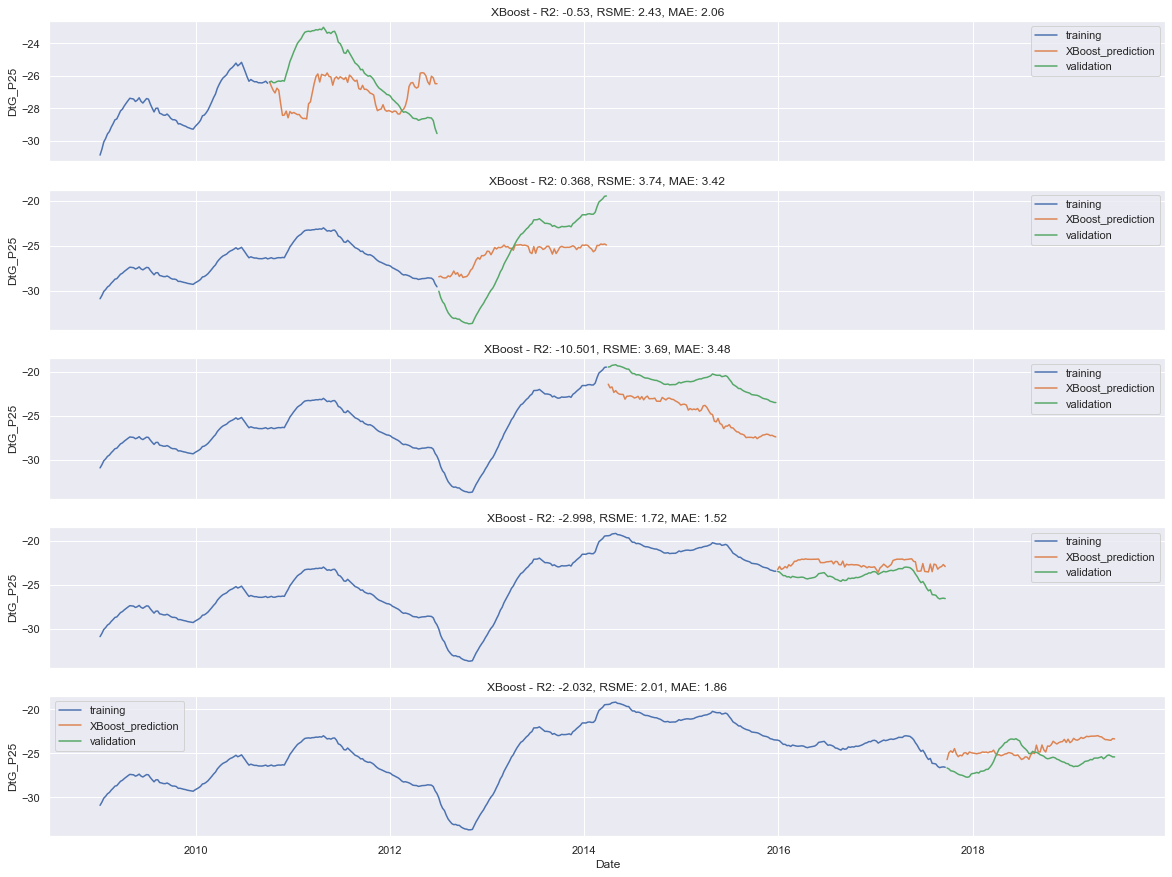

In [1410]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(20,15), sharex=True)
for i in range(5):
    boost.fit(X_training[i], y_training[i])
    prediction = pd.Series(boost.predict(X_validation[i]), index=X_validation[i].index)
    
    sns.lineplot(x = y_training[i].index, y=y_training[i], label='training', ax=ax[i])
    sns.lineplot(x = prediction.index, y=prediction, label='XBoost_prediction', ax=ax[i])
    sns.lineplot(x = y_validation[i].index, y=y_validation[i], label='validation', ax=ax[i])
    ax[i].set_title(f'XBoost - R2: {round(r2_score(y_validation[i], prediction),3)}, RSME: {RSME(y_validation[i], prediction)}, MAE: {MAE(y_validation[i], prediction)}')
plt.show()

### Xboost on Test

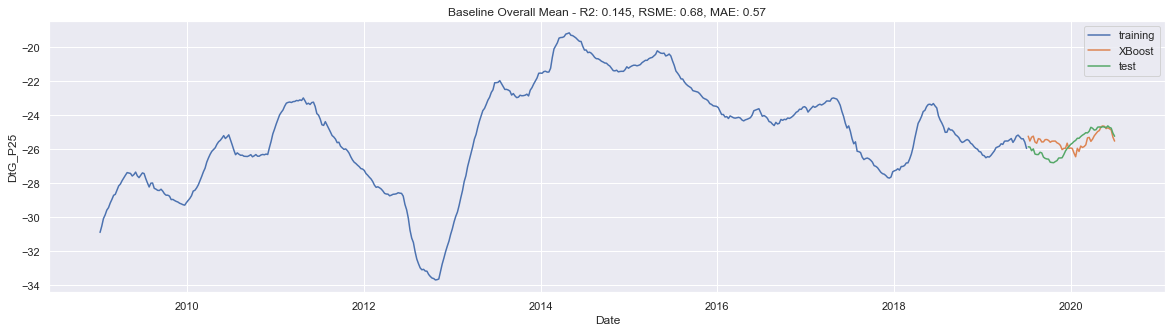

In [1411]:
boost.fit(X_train, y_train)
boost_forecast = boost.predict(X_test)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
sns.lineplot(x = y_train.index, y=y_train, label='training')
sns.lineplot(x = test.index, y=boost_forecast, label='XBoost')
sns.lineplot(x = test.index, y=y_test, label='test')
ax.set_title(f'Baseline Overall Mean - R2: {round(r2_score(y_test, boost_forecast),3)}, RSME: {RSME(y_test, boost_forecast)}, MAE: {MAE(y_test, boost_forecast)}')
plt.show()